In [1]:
#%pip install plot_keras_history

In [2]:
#%pip install mlflow

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image

from plot_keras_history import show_history, plot_history

# Tracking
import mlflow
from mlflow.tracking import MlflowClient
from mlflow import set_tracking_uri

C:\Users\John\Desktop\venv\lib\site-packages\pydantic\_internal\_fields.py:151: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
C:\Users\John\Desktop\venv\lib\site-packages\pydantic\_internal\_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
t1 = time.time()

In [6]:
# MLFLOW : Create an MLflow client (don't forget mlflow ui in CLI)
client = MlflowClient()

mlflow.set_experiment('Anomaly_detection')

mlflow.start_run(run_name = 'Screw_Anomaly')
run = mlflow.active_run()

In [7]:
# Définissons les chemins vers les dossier d'entraînement et de test
TRAIN_PATH = "./screw-dataset/train/"
TEST_PATH = "./screw-dataset/test/"

In [8]:
# Récupérons le dataframe avec les données d'entraînement (chemin vers les images + classe)
df = pd.read_csv("./screw-dataset/train.csv")
# Par la suite on considère que c'est une classification "categorical" alors on convertit le target en "string"
df['anomaly'] = df['anomaly'].astype('string')
# On a besoin du chemin complet vers les images
df['filename'] = list(map(lambda x : os.path.join(TRAIN_PATH, x), df['filename']))
df.head()

,filename,anomaly
0,./screw-dataset/train/manipulated_front000.png,1
1,./screw-dataset/train/manipulated_front001.png,1
2,./screw-dataset/train/manipulated_front002.png,1
3,./screw-dataset/train/manipulated_front003.png,1
4,./screw-dataset/train/manipulated_front004.png,1


In [9]:
# divisons le en un dataframe d'entraînement et un dataframe de validation
df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['anomaly'])
print("df_train.shape : ",df_train.shape)
print("df_val.shape : ",df_val.shape)

df_train.shape :  (240, 2)
df_val.shape :  (60, 2)


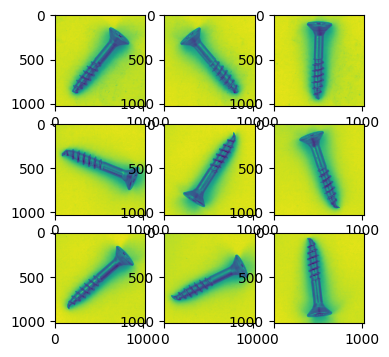

In [10]:
# Visualisons quelques images du dossier train
fig, ax = plt.subplots(3, 3, figsize=(4, 4))
k = 0
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(plt.imread(os.path.join(TRAIN_PATH, os.listdir(TRAIN_PATH)[k])))
        k += 1

In [11]:
# Récupération modèle pré-entraîné
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

# Layer non entraînables = on garde les poids du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Récupérer la sortie de ce réseau
x = base_model.output
# Compléter le modèle (le premier paramètre de "predictions" est le nombre de classes)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Définir le nouveau modèle
model = Model(inputs=base_model.input, outputs=predictions)
# compilation du modèle 
model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

#print(model.summary())

In [12]:
# Augmentation des données
train_datagen = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        #zoom_range = 1.1,
        horizontal_flip = True
        )

test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input)

In [13]:
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='anomaly',
    batch_size= 16,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='anomaly',
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    batch_size=16,
    class_mode='categorical',
    classes=['.']
)

Found 240 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.
Found 180 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


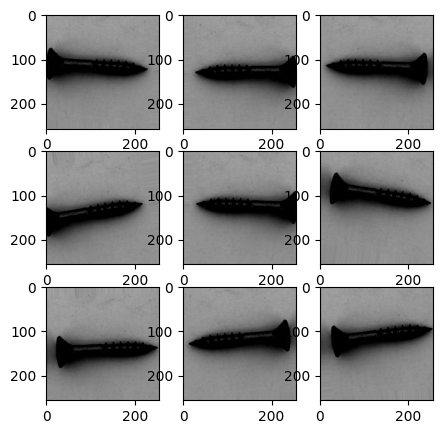

In [14]:
# Visualisons quelques images augmentées
augmented_images = [train_generator[0][0][0] for i in range(9)]
k = 0
fig, ax = plt.subplots(3, 3, figsize=(5,5))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(augmented_images[k])
        k +=1

In [15]:
# Création du callback pour sauvegarder le meilleur modèle sur la val_loss min
model_save_path = "./model.keras"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [16]:
# Entraînement du modèle
with tf.device('/gpu:1'): 
    history = model.fit(train_generator,
                    validation_data=val_generator,
                    batch_size=16, epochs=2, callbacks=callbacks_list, verbose=1)

Epoch 1/2


15/15 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.7875
Epoch 1: val_loss improved from inf to 0.50073, saving model to .\model.keras
15/15 [==============================] - 23s 1s/step - loss: 0.6550 - accuracy: 0.7875 - val_loss: 0.5007 - val_accuracy: 0.8333
Epoch 2/2
15/15 [==============================] - ETA: 0s - loss: 0.5205 - accuracy: 0.8000
Epoch 2: val_loss improved from 0.50073 to 0.43257, saving model to .\model.keras
15/15 [==============================] - 18s 1s/step - loss: 0.5205 - accuracy: 0.8000 - val_loss: 0.4326 - val_accuracy: 0.8333


In [17]:
# MLFLOW
nested_run = mlflow.start_run(nested=True, run_name='MobilenetV2_Transfer_Learning')
#mlflow.keras.log_model(model,'MobileNetV2')
mlflow.log_param('loss', model.loss)
mlflow.log_param('optimizer', model.optimizer.name)
mlflow.log_param('metrics', model.metrics[1].name)
mlflow.tensorflow.log_model(model,'MobileNetV2')

2024/05/15 19:10:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\John\AppData\Local\Temp\tmpcg9kzi4b\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\John\AppData\Local\Temp\tmpcg9kzi4b\model\data\model\assets


In [18]:
# Score du dernier epoch
with tf.device('/gpu:1'): 
    loss, accuracy = model.evaluate(train_generator, verbose=True)
    print("Training Accuracy   : {:.4f}".format(accuracy))
    #MLFLOW
    mlflow.log_metric("Training_loss",loss)
    mlflow.log_metric("Training_accuracy",accuracy)
    loss, accuracy = model.evaluate(val_generator, verbose=True)
    print("Validation Accuracy :  {:.4f}".format(accuracy))
    #MLFLOW
    mlflow.log_metric("Validation_loss",loss)
    mlflow.log_metric("Validation_accuracy",accuracy)

15/15 [==============================] - 17s 1s/step - loss: 0.3788 - accuracy: 0.8375
Training Accuracy   : 0.8375
4/4 [==============================] - 3s 620ms/step - loss: 0.4326 - accuracy: 0.8333
Validation Accuracy :  0.8333


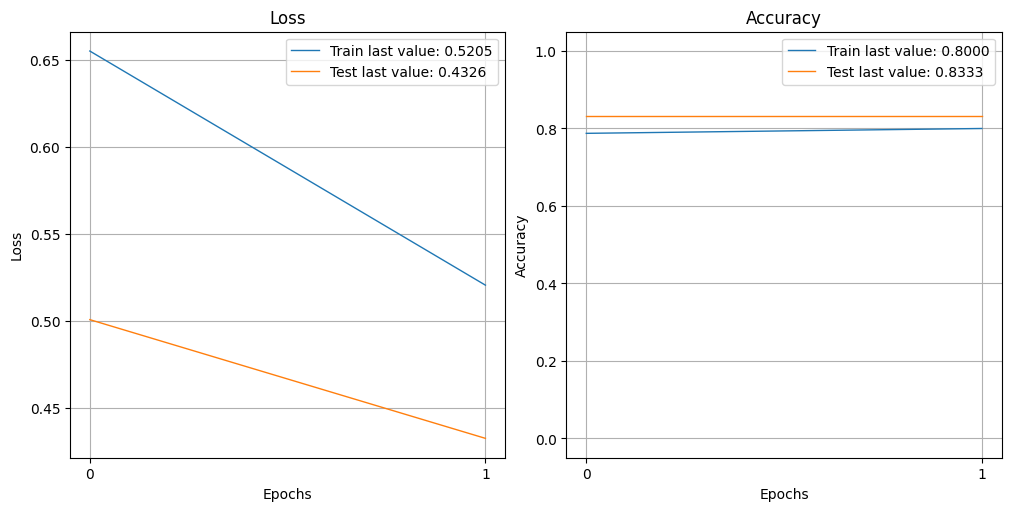

In [19]:
# Visualisons les courbes d'apprentissage du modèle en terme de val_loss et d'accuracy
show_history(history)
plot_history(history, path="history.png")
plt.close()

In [20]:
# MLFLOW
mlflow.log_artifact("history.png", "artifacts")
mlflow.end_run()

In [21]:
# Sur CPU : 1,30mn
# Sur GPU T4 x2 : 1,05mn
# Sur GPU 100 : 0,99mn
print("processing time : ",(time.time()-t1)/60,"mn")

processing time :  1.9732476075490315 mn


# Inférence

In [22]:
# Charger et préprocesser une image
img_path = "./screw-dataset/test/test_0.png"
img_height, img_width = 256, 256  # Adjust according to your model's input shape
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image pixel values

In [23]:
# Prédire la classe de l'image
predictions = model.predict(img_array)

predicted_class = np.argmax(predictions, axis=1)
confidence = np.max(predictions)

print("Predicted class:", predicted_class)
print("Confidence:", confidence)

1/1 [==============================] - 1s 1s/step
Predicted class: [0]
Confidence: 0.91690874
